In [180]:
import os
import cv2
import numpy as np
import pyautogui
import pygetwindow as gw
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass

In [184]:
def get_img_region(img, region):
    x, y, w, h = region
    return img[y:y+h, x:x+w]

def get_rgb_img_region(img, region=None):
    rgb_img = img
    if region is None:
        return rgb_img

    x, y, w, h = region
    return rgb_img[y:y+h, x:x+w]

def get_hsv_img_region(img, region=None):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if region is None:
        return hsv_img

    x, y, w, h = region
    return hsv_img[y:y+h, x:x+w]

In [185]:
axie_width = 180
axie_height = 120
axie_target_height = 50

H0, S0, V0 = 24, 145, 251
dH, dS, dV = 2, 15, 50

lower = np.array([
    max(H0 - dH, 0),
    max(S0 - dS, 0),
    max(V0 - dV, 0)
], dtype=np.uint8)

upper = np.array([
    min(H0 + dH, 179),  # Hue 上限 179
    min(S0 + dS, 255),
    min(V0 + dV, 255)
], dtype=np.uint8)

target_filter = np.load("axie_target_filter.npy")

@dataclass
class Slot:
    name: str
    region: tuple[int, int, int, int]
    region_center: tuple[int, int]
    target_region: tuple[int, int, int, int]
    threshold: float
    priority: int

    def __init__(self, name, region, threshold=5, priority=1):
        self.name = name
        self.region = region
        self.threshold = threshold
        self.priority = priority

        x, y, w, h = region
        self.target_region = (x, y + h - 25, w, axie_target_height)
        self.region_center = (x + w/2, y + h/2)

    def is_target(self, img):
        mask = cv2.inRange(get_hsv_img_region(img, self.target_region), lower, upper)
        mask = mask * target_filter
        return mask.mean() > self.threshold

    def get_mask_mean(self, img):
        mask = cv2.inRange(get_hsv_img_region(img, self.target_region), lower, upper)
        mask = mask * target_filter
        return mask.mean()

    def get_mask(self, img):
        mask = cv2.inRange(get_hsv_img_region(img, self.target_region), lower, upper)
        # mask = mask * target_filter
        return mask

    def get_region_rgb(self, img):
        return get_rgb_img_region(img, self.region)

    def get_target_region_rgb(self, img):
        return get_rgb_img_region(img, self.target_region)

In [248]:
axie_slot_ally_1 = Slot("ally1", (585, 438, axie_width, axie_height))
axie_slot_ally_2 = Slot("ally2", (485, 550, axie_width, axie_height))
axie_slot_ally_3 = Slot("ally3", (385, 438, axie_width, axie_height))
axie_slot_ally_4 = Slot("ally4", (285, 550, axie_width, axie_height))
axie_slot_ally_5 = Slot("ally5", (185, 438, axie_width, axie_height))
axie_slot_ally_6 = Slot("ally6", (85, 550, axie_width, axie_height))
ally_slots = [
    axie_slot_ally_1,
    axie_slot_ally_2,
    axie_slot_ally_3,
    axie_slot_ally_4,
    axie_slot_ally_5,
    axie_slot_ally_6,
]

axie_slot_enemy_1 = Slot("enemy1", (835, 550, axie_width, axie_height))
axie_slot_enemy_2 = Slot("enemy2", (935, 438, axie_width, axie_height))
axie_slot_enemy_3 = Slot("enemy3", (1035, 550, axie_width, axie_height))
axie_slot_enemy_4 = Slot("enemy4", (1135, 438, axie_width, axie_height))
axie_slot_enemy_5 = Slot("enemy5", (1235, 550, axie_width, axie_height))
axie_slot_enemy_6 = Slot("enemy6", (1335, 438, axie_width, axie_height))
enemy_slots = [
    axie_slot_enemy_1,
    axie_slot_enemy_2,
    axie_slot_enemy_3,
    axie_slot_enemy_4,
    axie_slot_enemy_5,
    axie_slot_enemy_6,
]

all_slots = ally_slots + enemy_slots
all_slots

[Slot(name='ally1', region=(585, 438, 180, 120), region_center=(675.0, 498.0), target_region=(585, 533, 180, 50), threshold=5, priority=1),
 Slot(name='ally2', region=(485, 550, 180, 120), region_center=(575.0, 610.0), target_region=(485, 645, 180, 50), threshold=5, priority=1),
 Slot(name='ally3', region=(385, 438, 180, 120), region_center=(475.0, 498.0), target_region=(385, 533, 180, 50), threshold=5, priority=1),
 Slot(name='ally4', region=(285, 550, 180, 120), region_center=(375.0, 610.0), target_region=(285, 645, 180, 50), threshold=5, priority=1),
 Slot(name='ally5', region=(185, 438, 180, 120), region_center=(275.0, 498.0), target_region=(185, 533, 180, 50), threshold=5, priority=1),
 Slot(name='ally6', region=(85, 550, 180, 120), region_center=(175.0, 610.0), target_region=(85, 645, 180, 50), threshold=5, priority=1),
 Slot(name='enemy1', region=(835, 550, 180, 120), region_center=(925.0, 610.0), target_region=(835, 645, 180, 50), threshold=5, priority=1),
 Slot(name='enemy2', 

In [192]:
def find_tagrets(img):
    target_slots = [slot for slot in all_slots if slot.is_target(img)]
    return target_slots

In [109]:
### Test

[Slot(name='ally1', region=(585, 438, 180, 120), region_center=(675.0, 498.0), target_region=(585, 533, 180, 50), threshold=5, priority=1),
 Slot(name='ally4', region=(285, 550, 180, 120), region_center=(375.0, 610.0), target_region=(285, 645, 180, 50), threshold=5, priority=1)]

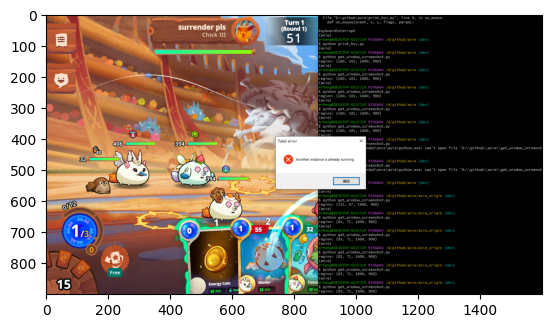

In [249]:
img1 = np.array(Image.open("test_images/window1.png"))
img2 = np.array(Image.open("test_images/window2.png"))
img3 = np.array(Image.open("test_images/window3.png"))
img4 = np.array(Image.open("test_images/window4.png"))
img5 = np.array(Image.open("test_images/window11.png"))

img = img5
plt.imshow(get_rgb_img_region(img))
find_tagrets(img)

np.float64(37.25833333333333)

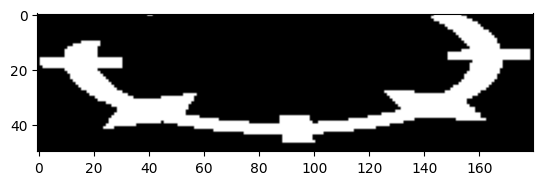

In [201]:
plt.imshow(axie_slot_ally_5.get_mask(img), cmap="gray")

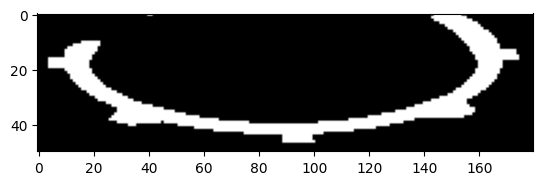

In [202]:
plt.imshow(axie_slot_ally_5.get_mask(img) * target_filter, cmap="gray")

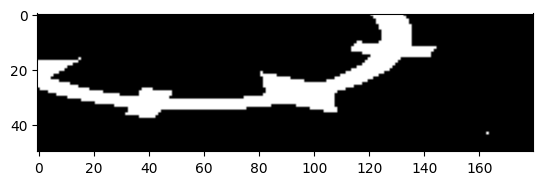

In [221]:
plt.imshow(axie_slot_enemy_2.get_mask(img5), cmap="gray")

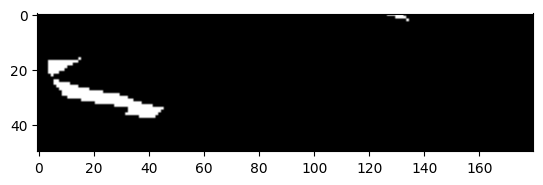

In [219]:
plt.imshow(axie_slot_enemy_2.get_mask(img5) * target_filter, cmap="gray")

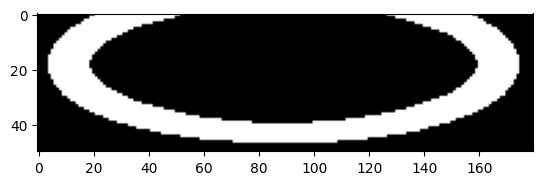

In [184]:
arr = np.load("my_array_ring.npy")
plt.imshow(target_filter, cmap="gray")

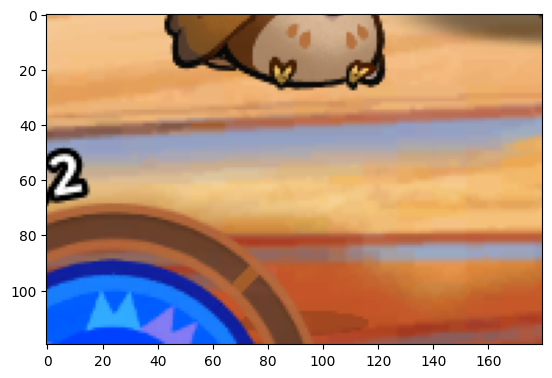

In [253]:
plt.imshow(axie_slot_ally_6.get_region_rgb(img5))

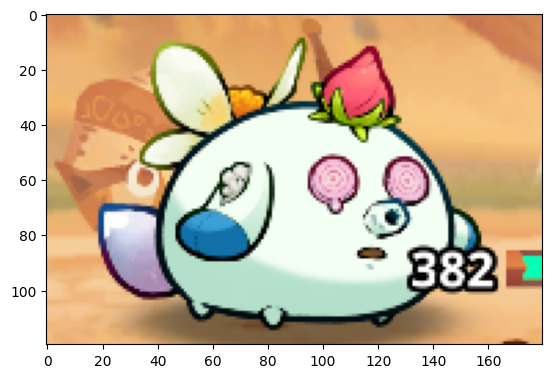

In [242]:
plt.imshow(axie_slot_ally_3.get_region_rgb(img5))

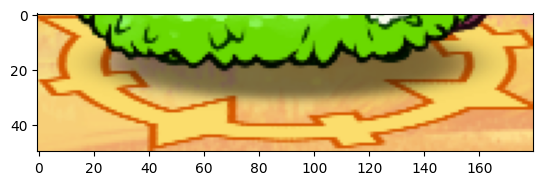

In [172]:
plt.imshow(axie_slot_enemy_2.get_target_region_rgb(img5))

In [193]:
x, y, w, h = axie["ally"]["slot5"]["target_resion"]           # 区域左上角(x,y)和宽高
roi = img[y:y+h, x:x+w]

In [156]:
x, y = 250,572
hsv_img[y, x]

array([ 24, 145, 251], dtype=uint8)

In [157]:
x, y = 260,572
hsv_img[y, x]

array([ 23, 149, 251], dtype=uint8)